In [1]:
#FUNCTION TO CLEAN A SINGLE DF
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import datetime
import os

col_names = ["Index", "DateD", "DateM", "DateY", "Time", "MonStatus", "Extras", "MonN", "TubeN", "DataType", "Unused", "Light"]

for i in range(1, 33):
    col_names.append(f"Sp{i}")

file = 'Steatoda B masking 10pm.txt'

df = pd.read_csv(file, names=col_names, sep='\s+', header=None)
df = df.set_index('Index')
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S', errors='coerce')
df = df[df["MonStatus"] == 1]


month_map = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6}
df['DateM'] = df['DateM'].str[:3].map(month_map)
df['DateY'] = df['DateY'].apply(lambda x: int(str(20) + str(x)))
df['Date'] = pd.to_datetime(dict(year=df['DateY'], month=df['DateM'], day=df['DateD']), errors='coerce')

df['Time'] = pd.to_datetime(dict(year=df['Date'].dt.year,
                                     month=df['Date'].dt.month,
                                     day=df['Date'].dt.day,
                                     hour=df['Time'].dt.hour,
                                     minute=df['Time'].dt.minute,
                                     second=df['Time'].dt.second))

df = df.drop(["DateD", "DateM", "DateY", "Date", "MonStatus", "Extras", "MonN", "TubeN", "DataType", "Unused"], axis=1)

day_map = {day: idx+1 for idx, day in enumerate(df['Time'].dt.day.unique())}

df.insert(0, 'Day', df['Time'].dt.day.map(day_map))

#df.to_csv('steatodaA.csv')

#FUNCTION TO FILTER THRESHOLD ON A SINGLE FILE
import pandas as pd

def filter_and_merge(df, threshold=0):
    additional_columns = df.columns[:3]
    filtered_dfs = []

    for day in range(1, 9):  
        day_df = df[df['Day'] == day] 
        count_mov = day_df.filter(like="Sp")  
        x = count_mov.sum(axis=0)  
        z = x > threshold  
        columns_to_keep = z[z].index 
        
        all_columns_to_keep = list(additional_columns) + list(columns_to_keep)
        filtered_df = day_df[all_columns_to_keep]
        filtered_dfs.append(filtered_df)

    merged_df = pd.concat(filtered_dfs)
    merged_df1 = merged_df.dropna(axis=1)
    
    return merged_df1
    
merged_df = filter_and_merge(df)

#CODE TO TEST FOR ENTRAINMENT
import numpy as np

def entrainment(data, column):
    if column not in data.columns:
        return False
    
    dflight = data[data['Light'] == 1][column]
    dfdark = data[data['Light'] == 0][column]
    
    lightmean = np.mean(dflight)
    darkmean = np.mean(dfdark)
    
    if darkmean == 0:
        return False
    
    diff = lightmean / darkmean
    return diff > 0.25

spiders = ["Sp"+str(i) for i in range(1, 33)]

entrainment_results = []

for spider_column in spiders:
    if spider_column in merged_df.columns:  # Check if the column exists
        entrainment_result = entrainment(merged_df, spider_column)
        entrainment_results.append((spider_column, entrainment_result))

results_df = pd.DataFrame(entrainment_results, columns=['Spider', 'Entrained'])

entrained_spiders = results_df[results_df['Entrained'] == True]['Spider'].tolist()

#CODE TO FILTER ENTRAINMENT
finaldf = []

additional_columns = merged_df.columns[:3]
columns_to_keep = entrained_spiders
        
all_columns_to_keep = list(additional_columns) + list(columns_to_keep)
filtered_df = merged_df[all_columns_to_keep]  # Use merged_df here, not entrained_spiders

finaldf.append(filtered_df)

merged_dfx = pd.concat(finaldf)
merged_dfx1 = merged_dfx.dropna(axis=1)  # Use merged_dfx here, not merged_df

display(merged_dfx1)

,Day,Time,Light,Sp3,Sp4,Sp7,Sp9,Sp11,Sp12,Sp13,Sp14,Sp15,Sp17,Sp19,Sp21
Index,,,,,,,,,,,,,,,
14,1,2024-04-17 15:56:00,1,0,16,2,0,0,26,0,0,0,0,2,0
15,1,2024-04-17 15:57:00,1,0,8,3,0,0,17,0,0,0,0,1,0
16,1,2024-04-17 15:58:00,1,0,8,4,0,0,19,0,0,0,0,6,0
17,1,2024-04-17 15:59:00,1,0,15,2,0,0,11,0,0,0,0,1,0
18,1,2024-04-17 16:00:00,1,0,9,2,0,0,14,6,0,0,0,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10036,8,2024-04-24 14:58:00,1,0,0,0,0,0,0,0,0,0,0,0,0
10037,8,2024-04-24 14:59:00,1,0,0,0,0,0,0,0,0,0,0,0,0
10038,8,2024-04-24 15:00:00,1,0,0,0,0,0,0,0,0,0,0,0,0


In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import os

def filter_and_compare_activity(df, day_pulse, day_pre_pulse, start_hour, end_hour, output_folder):
    # Create a new folder to store the figures
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Define the range of days for the pre-pulse period
    pre_pulse_days = [2, 3, 4]

    # Get the unique dates for the specified days
    pre_pulse_dates = df.loc[df['Day'].isin(pre_pulse_days), 'Time'].dt.date.unique()
    pulse_date = df.loc[df['Day'] == day_pulse, 'Time'].dt.date.unique()[0]
    
    # Construct start and end times with the correct dates
    start_time_pre_pulse = pd.to_datetime(f"{pre_pulse_dates[0]} {start_hour}")
    end_time_pre_pulse = pd.to_datetime(f"{pre_pulse_dates[-1]} {end_hour}")
    start_time_pulse = pd.to_datetime(f"{pulse_date} {start_hour}")
    end_time_pulse = pd.to_datetime(f"{pulse_date} {end_hour}")
    
    # Filter the days
    days_pre_pulse = df.loc[df['Day'].isin(pre_pulse_days)]
    day_pulse = df.loc[df['Day'] == day_pulse]
    
    # Filter the time range for the specified days
    day_pre_pulse_filtered = days_pre_pulse[(days_pre_pulse['Time'] >= start_time_pre_pulse) & (days_pre_pulse['Time'] <= end_time_pre_pulse)]
    day_pulse_filtered = day_pulse[(day_pulse['Time'] >= start_time_pulse) & (day_pulse['Time'] <= end_time_pulse)]
    
    for spider_col in df.columns:
        if spider_col.startswith('Sp'):
            # Calculate the mean activity and standard error of the mean for each spider column
            mean_day_pre_pulse = day_pre_pulse_filtered[spider_col].mean()
            mean_day_pulse = day_pulse_filtered[spider_col].mean()
            sem_day_pre_pulse = day_pre_pulse_filtered[spider_col].sem()
            sem_day_pulse = day_pulse_filtered[spider_col].sem()
            
            # Plot the results with error bars
            plt.figure(figsize=(7, 5))  # Adjust figsize for better spacing
            plt.bar(['Pre-pulse days 2-4', '2-hour pulse'], [mean_day_pre_pulse, mean_day_pulse],
                    yerr=[sem_day_pre_pulse, sem_day_pulse], capsize=5)
            plt.suptitle(f'Comparison in activity for {spider_col} with and without the 2-hour pulse', fontsize=14)
            plt.ylabel('Average activity', fontsize=12)
            plt.xlabel('Time period', fontsize=12)
            plt.xticks(fontsize=10)
            plt.yticks(fontsize=10)
            plt.tight_layout()  # Adjust layout to prevent cutting off labels
            
            # Save the figure with a filename indicating the comparison and spider column name
            filename = f"{output_folder}/comparison_graph_{spider_col}.png"
            plt.savefig(filename)
            plt.close()  # Close the figure to free up memory

# Example usage
day_pulse = 5 
day_pre_pulse = 4  
start_hour = '22:00:00' 
end_hour = '23:59:00'  

df['Time'] = pd.to_datetime(df['Time'])

# Original file name (replace with your actual file name)
original_filename = "10pm_B.csv"

# Create a new folder with the same name as the original file (without extension)
output_folder = os.path.splitext(original_filename)[0] + "_figures"

filter_and_compare_activity(df, day_pulse, day_pre_pulse, start_hour, end_hour, output_folder)

# Ensure 'Time' is in datetime format
merged_df['Time'] = pd.to_datetime(merged_df['Time'])

filter_and_compare_activity(merged_df, day_pulse, day_pre_pulse, start_hour, end_hour, output_folder)

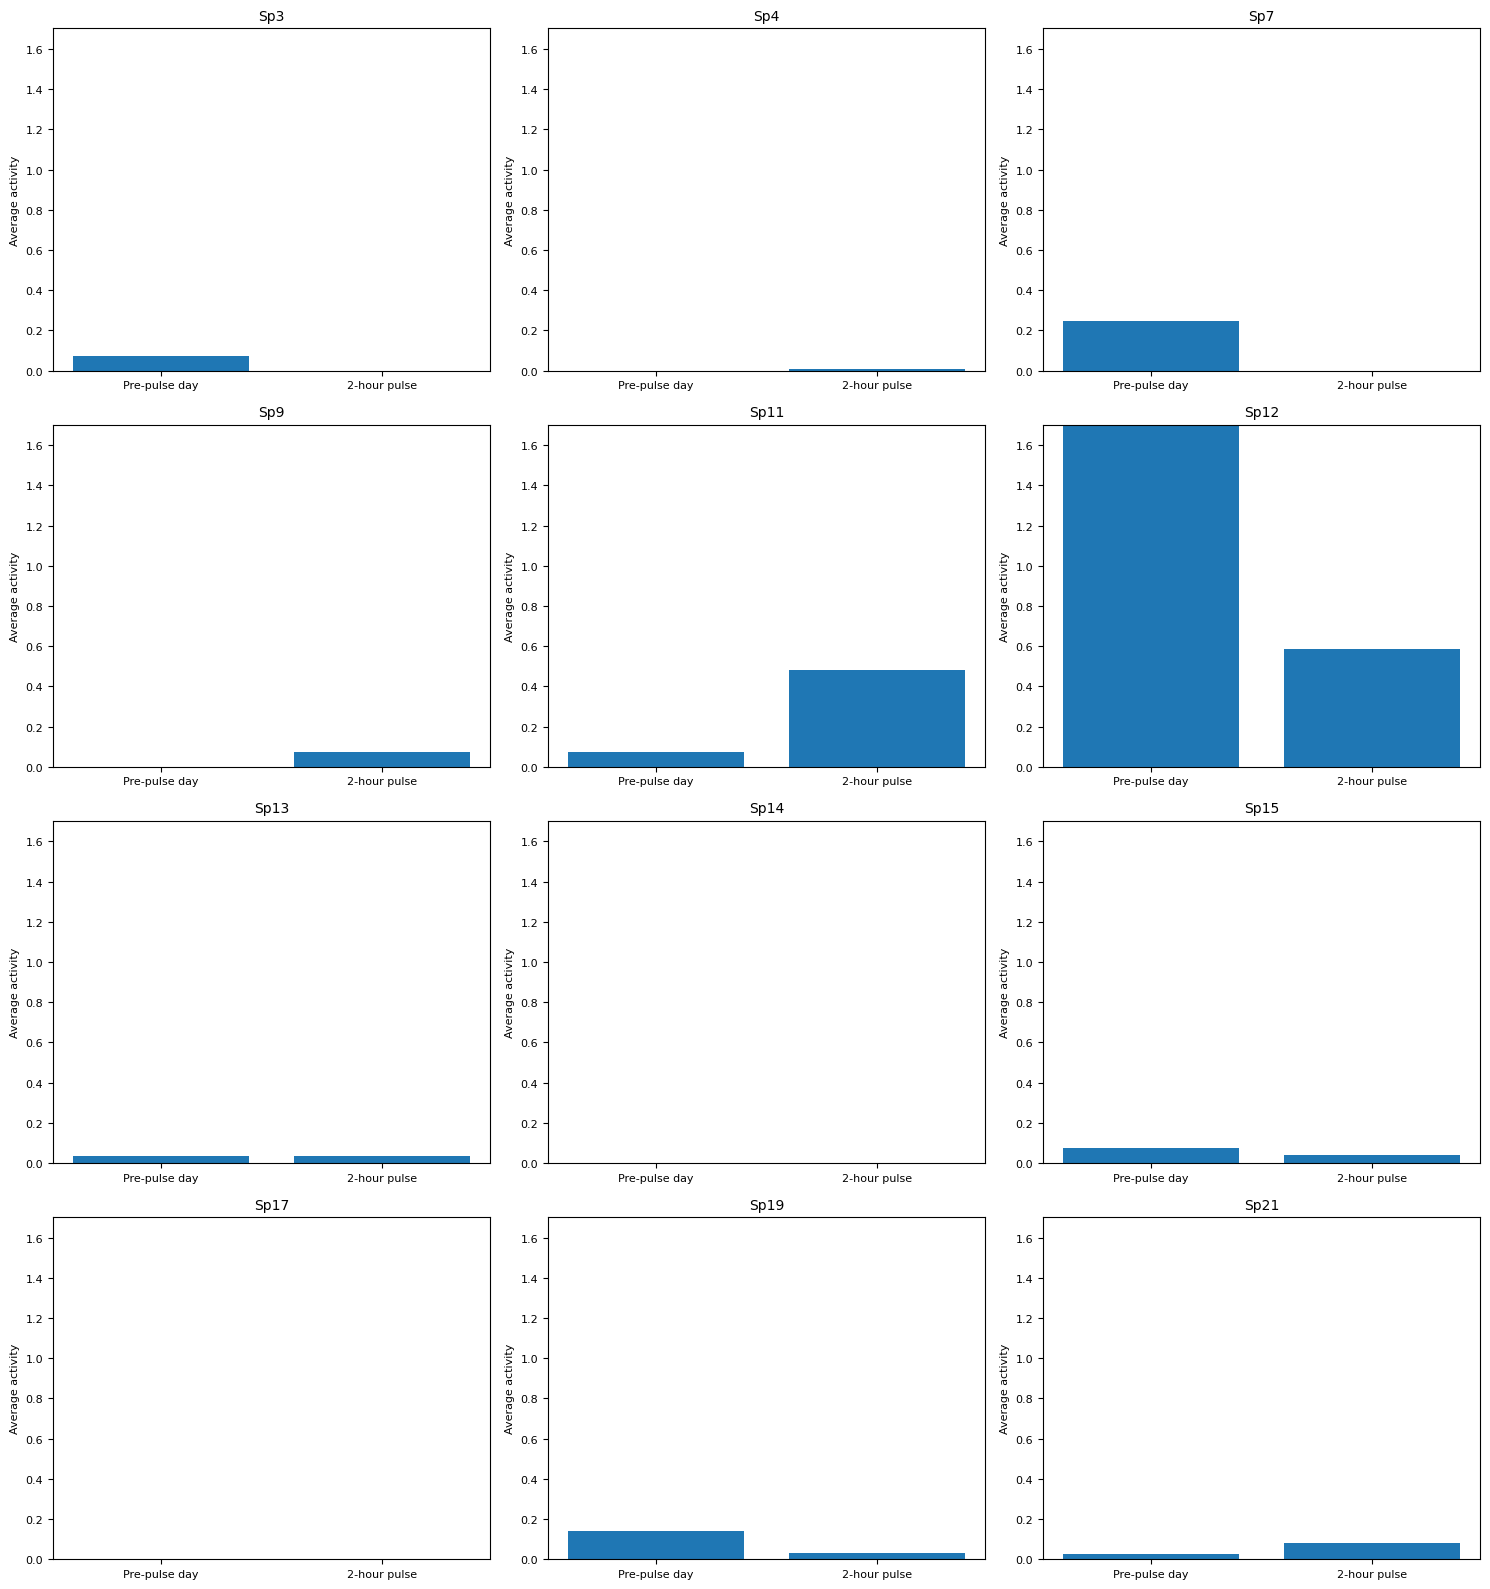

   Spider  Mean Pre-pulse Activity  Mean Pulse Activity
0     Sp3                 0.074380             0.000000
1     Sp4                 0.000000             0.008264
2     Sp7                 0.247934             0.000000
3     Sp9                 0.000000             0.074380
4    Sp11                 0.074380             0.479339
5    Sp12                 1.702479             0.586777
6    Sp13                 0.033058             0.033058
7    Sp14                 0.000000             0.000000
8    Sp15                 0.074380             0.041322
9    Sp17                 0.000000             0.000000
10   Sp19                 0.140496             0.033058
11   Sp21                 0.024793             0.082645


In [3]:
#FUNCTION FOR PLOTTING ALL SPIDERS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def filter_and_compare_activity(df, day_pulse, day_pre_pulse, start_hour, end_hour):
    # Get the unique dates for the specified days
    pre_pulse_date = df.loc[df['Day'] == day_pre_pulse, 'Time'].dt.date.unique()[0]
    pulse_date = df.loc[df['Day'] == day_pulse, 'Time'].dt.date.unique()[0]
    
    # Construct start and end times with the correct dates
    start_time_pre_pulse = pd.to_datetime(f"{pre_pulse_date} {start_hour}")
    end_time_pre_pulse = pd.to_datetime(f"{pre_pulse_date} {end_hour}")
    start_time_pulse = pd.to_datetime(f"{pulse_date} {start_hour}")
    end_time_pulse = pd.to_datetime(f"{pulse_date} {end_hour}")
    
    # Filter the days
    day_pre = df.loc[df['Day'] == day_pre_pulse]
    day_pulse = df.loc[df['Day'] == day_pulse]
    
    # Filter the time range for the specified days
    day_pre_filtered = day_pre[(day_pre['Time'] >= start_time_pre_pulse) & (day_pre['Time'] <= end_time_pre_pulse)]
    day_pulse_filtered = day_pulse[(day_pulse['Time'] >= start_time_pulse) & (day_pulse['Time'] <= end_time_pulse)]
    
    # Initialize a list to store mean activity data for each spider
    spider_means = []
    
    # Loop through each spider column
    spider_columns = [col for col in df.columns if col.startswith('Sp')]
    
    # Calculate the number of rows and columns for the grid
    num_spiders = len(spider_columns)
    num_cols = 3  # You can adjust this value based on how many columns you want in the grid
    num_rows = (num_spiders + num_cols - 1) // num_cols  # Calculate the number of rows needed

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 4))
    axes = axes.flatten()  # Flatten the axes array to easily index it
    
    for idx, spider_col in enumerate(spider_columns):
        # Filter for the specific spider column
        spider_day_pre = day_pre_filtered[spider_col]
        spider_day_pulse = day_pulse_filtered[spider_col]
        
        # Calculate the mean activity
        mean_day_pre = spider_day_pre.mean()
        mean_day_pulse = spider_day_pulse.mean()
        
        # Append the results to the spider_means list
        spider_means.append((spider_col, mean_day_pre, mean_day_pulse))
        
        # Plot the results for each spider in the grid
        ax = axes[idx]
        days = ['Pre-pulse day', '2-hour pulse']
        means = [mean_day_pre, mean_day_pulse]
        
        ax.bar(days, means)
        ax.set_title(f'{spider_col}', fontsize=10)
        ax.set_ylabel('Average activity', fontsize=8)
        ax.set_xticks([0, 1])
        ax.set_xticklabels(days, fontsize=8)
        ax.tick_params(axis='y', labelsize=8)
    
    # Remove any empty subplots
    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])
    
    # Find the maximum mean activity across all spiders
    max_mean_activity = max([mean for _, mean_pre, mean_pulse in spider_means for mean in (mean_pre, mean_pulse)])
    
    # Set the same y-axis range for all subplots
    for ax in axes:
        ax.set_ylim(0, max_mean_activity)
    
    plt.tight_layout()
    plt.show()
    
    # Create a DataFrame to store the means for all spiders
    means_df = pd.DataFrame(spider_means, columns=['Spider', 'Mean Pre-pulse Activity', 'Mean Pulse Activity'])
    
    return means_df

# Example usage
# Define the parameters
day_pulse = 5  # The day when the pulse occurred
day_pre_pulse = 4  # The day before the pulse
start_hour = '14:00:00'  # Replace with the desired start hour
end_hour = '16:00:00'  # Replace with the desired end hour

# Ensure 'Time' is in datetime format
merged_dfx1['Time'] = pd.to_datetime(merged_dfx1['Time'])

# Call the function using the existing df
means_df = filter_and_compare_activity(merged_dfx1, day_pulse, day_pre_pulse, start_hour, end_hour)
print(means_df)

In [4]:
#TRYING TO GET IT ALL TOGETHER SO I CAN PLOT FOR ALL AT ONCE?



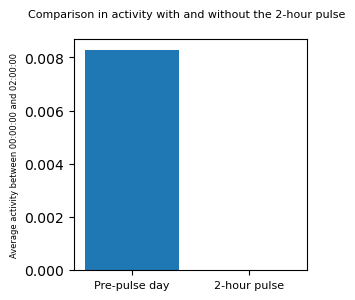

In [5]:
#FUNCTION FOR PLOTTING
import pandas as pd
import matplotlib.pyplot as plt

def filter_and_compare_activity(df, spider_col, day_pulse, day_pre_pulse, start_hour, end_hour):
    pre_pulse_date = df.loc[df['Day'] == day_pre_pulse, 'Time'].dt.date.unique()[0]
    pulse_date = df.loc[df['Day'] == day_pulse, 'Time'].dt.date.unique()[0]
    
    start_time_pre_pulse = pd.to_datetime(f"{pre_pulse_date} {start_hour}")
    end_time_pre_pulse = pd.to_datetime(f"{pre_pulse_date} {end_hour}")
    start_time_pulse = pd.to_datetime(f"{pulse_date} {start_hour}")
    end_time_pulse = pd.to_datetime(f"{pulse_date} {end_hour}")
    
    day_pre = df.loc[df['Day'] == day_pre_pulse]
    day_pulse = df.loc[df['Day'] == day_pulse]
    
    day_pre_filtered = day_pre[(day_pre['Time'] >= start_time_pre_pulse) & (day_pre['Time'] <= end_time_pre_pulse)]
    day_pulse_filtered = day_pulse[(day_pulse['Time'] >= start_time_pulse) & (day_pulse['Time'] <= end_time_pulse)]
    
    spider_day_pre = day_pre_filtered[spider_col]
    spider_day_pulse = day_pulse_filtered[spider_col]
    
    mean_day_pre = spider_day_pre.mean()
    mean_day_pulse = spider_day_pulse.mean()
    
    means_df = pd.DataFrame({
        'Day': ['Pre-pulse day', '2-hour pulse'],
        'Mean Activity': [mean_day_pre, mean_day_pulse]
    })
    
    # Plot the results
    plt.figure(figsize=(3, 3))
    plt.bar(means_df['Day'], means_df['Mean Activity'])
    plt.suptitle('Comparison in activity with and without the 2-hour pulse', fontsize=8)
    plt.ylabel('Average activity between {} and {}'.format(start_hour, end_hour), fontsize=6)
    plt.xticks(fontsize=8)
    plt.show()
    
    return means_df

spider_col = 'Sp15'  
day_pulse = 5 
day_pre_pulse = 4  
start_hour = '00:00:00' 
end_hour = '02:00:00'  

merged_df['Time'] = pd.to_datetime(merged_df['Time'])

means_df = filter_and_compare_activity(merged_df, spider_col, day_pulse, day_pre_pulse, start_hour, end_hour)

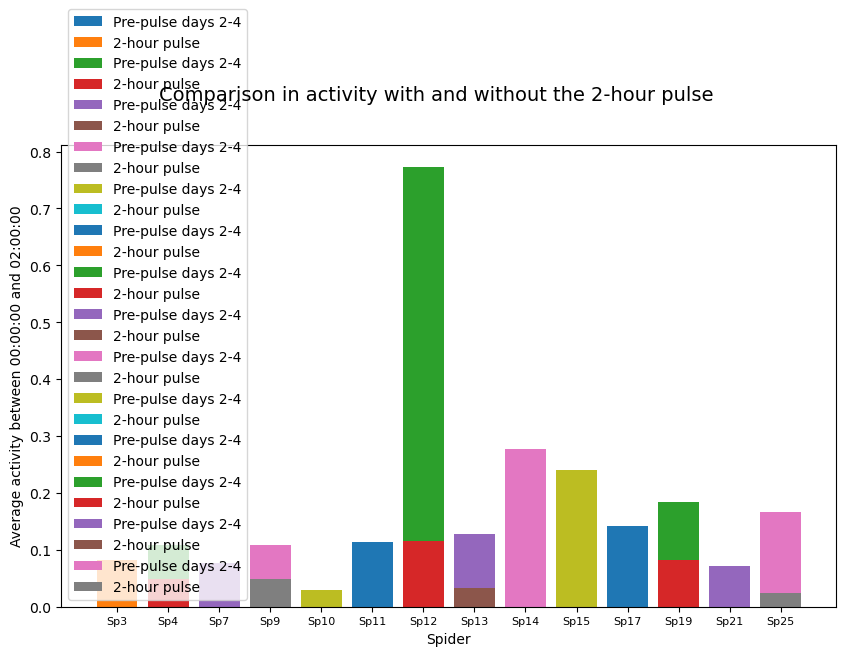

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

def filter_and_compare_activity(df, day_pulse, day_pre_pulse, start_hour, end_hour):
    # Define the range of days for the pre-pulse period
    pre_pulse_days = [2, 3, 4]

    # Get the unique dates for the specified days
    pre_pulse_dates = df.loc[df['Day'].isin(pre_pulse_days), 'Time'].dt.date.unique()
    pulse_date = df.loc[df['Day'] == day_pulse, 'Time'].dt.date.unique()[0]
    
    # Construct start and end times with the correct dates
    start_time_pre_pulse = pd.to_datetime(f"{pre_pulse_dates[0]} {start_hour}")
    end_time_pre_pulse = pd.to_datetime(f"{pre_pulse_dates[-1]} {end_hour}")
    start_time_pulse = pd.to_datetime(f"{pulse_date} {start_hour}")
    end_time_pulse = pd.to_datetime(f"{pulse_date} {end_hour}")
    
    # Filter the days
    days_pre_pulse = df.loc[df['Day'].isin(pre_pulse_days)]
    day_pulse = df.loc[df['Day'] == day_pulse]
    
    # Filter the time range for the specified days
    day_pre_pulse_filtered = days_pre_pulse[(days_pre_pulse['Time'] >= start_time_pre_pulse) & (days_pre_pulse['Time'] <= end_time_pre_pulse)]
    day_pulse_filtered = day_pulse[(day_pulse['Time'] >= start_time_pulse) & (day_pulse['Time'] <= end_time_pulse)]
    
    means = []
    for spider_col in df.columns:
        if spider_col.startswith('Sp'):
            # Calculate the mean activity for each spider column
            mean_day_pre_pulse = day_pre_pulse_filtered[spider_col].mean()
            mean_day_pulse = day_pulse_filtered[spider_col].mean()
            
            means.append({
                'Spider': spider_col,
                'Pre-pulse days 2-4': mean_day_pre_pulse,
                '2-hour pulse': mean_day_pulse
            })
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    for spider_data in means:
        plt.bar(spider_data['Spider'], spider_data['Pre-pulse days 2-4'], label='Pre-pulse days 2-4')
        plt.bar(spider_data['Spider'], spider_data['2-hour pulse'], label='2-hour pulse')
    plt.suptitle('Comparison in activity with and without the 2-hour pulse', fontsize=14)
    plt.ylabel('Average activity between {} and {}'.format(start_hour, end_hour), fontsize=10)
    plt.xlabel('Spider', fontsize=10)
    plt.xticks(fontsize=8)
    plt.legend()
    plt.show()
    
    return pd.DataFrame(means)

# Example usage
day_pulse = 5 
day_pre_pulse = 4  
start_hour = '00:00:00' 
end_hour = '02:00:00'  

# Ensure 'Time' is in datetime format
merged_df['Time'] = pd.to_datetime(merged_df['Time'])

means_df = filter_and_compare_activity(merged_df, day_pulse, day_pre_pulse, start_hour, end_hour)

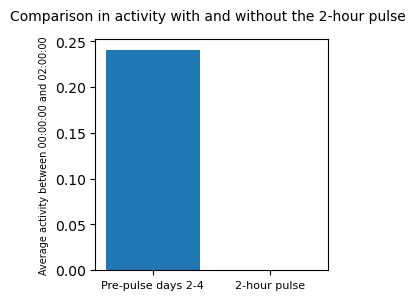

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

def filter_and_compare_activity(df, spider_col, day_pulse, day_pre_pulse, start_hour, end_hour):
    # Define the range of days for the pre-pulse period
    pre_pulse_days = [2, 3, 4]

    # Get the unique dates for the specified days
    pre_pulse_dates = df.loc[df['Day'].isin(pre_pulse_days), 'Time'].dt.date.unique()
    pulse_date = df.loc[df['Day'] == day_pulse, 'Time'].dt.date.unique()[0]
    
    # Construct start and end times with the correct dates
    start_time_pre_pulse = pd.to_datetime(f"{pre_pulse_dates[0]} {start_hour}")
    end_time_pre_pulse = pd.to_datetime(f"{pre_pulse_dates[-1]} {end_hour}")
    start_time_pulse = pd.to_datetime(f"{pulse_date} {start_hour}")
    end_time_pulse = pd.to_datetime(f"{pulse_date} {end_hour}")
    
    # Filter the days
    days_pre_pulse = df.loc[df['Day'].isin(pre_pulse_days)]
    day_pulse = df.loc[df['Day'] == day_pulse]
    
    # Filter the time range for the specified days
    day_pre_pulse_filtered = days_pre_pulse[(days_pre_pulse['Time'] >= start_time_pre_pulse) & (days_pre_pulse['Time'] <= end_time_pre_pulse)]
    day_pulse_filtered = day_pulse[(day_pulse['Time'] >= start_time_pulse) & (day_pulse['Time'] <= end_time_pulse)]
    
    # Calculate the mean activity
    mean_day_pre_pulse = day_pre_pulse_filtered[spider_col].mean()
    mean_day_pulse = day_pulse_filtered[spider_col].mean()
    
    means_df = pd.DataFrame({
        'Day': ['Pre-pulse days 2-4', '2-hour pulse'],
        'Mean Activity': [mean_day_pre_pulse, mean_day_pulse]
    })
    
    # Plot the results
    plt.figure(figsize=(3, 3))
    plt.bar(means_df['Day'], means_df['Mean Activity'])
    plt.suptitle('Comparison in activity with and without the 2-hour pulse', fontsize=10)
    plt.ylabel('Average activity between {} and {}'.format(start_hour, end_hour), fontsize=7)
    plt.xticks(fontsize=8)
    plt.show()
    
    return means_df

# Example usage
spider_col = 'Sp15'  
day_pulse = 5 
day_pre_pulse = 4  
start_hour = '00:00:00' 
end_hour = '02:00:00'  

# Ensure 'Time' is in datetime format
merged_df['Time'] = pd.to_datetime(merged_df['Time'])

means_df = filter_and_compare_activity(merged_df, spider_col, day_pulse, day_pre_pulse, start_hour, end_hour)

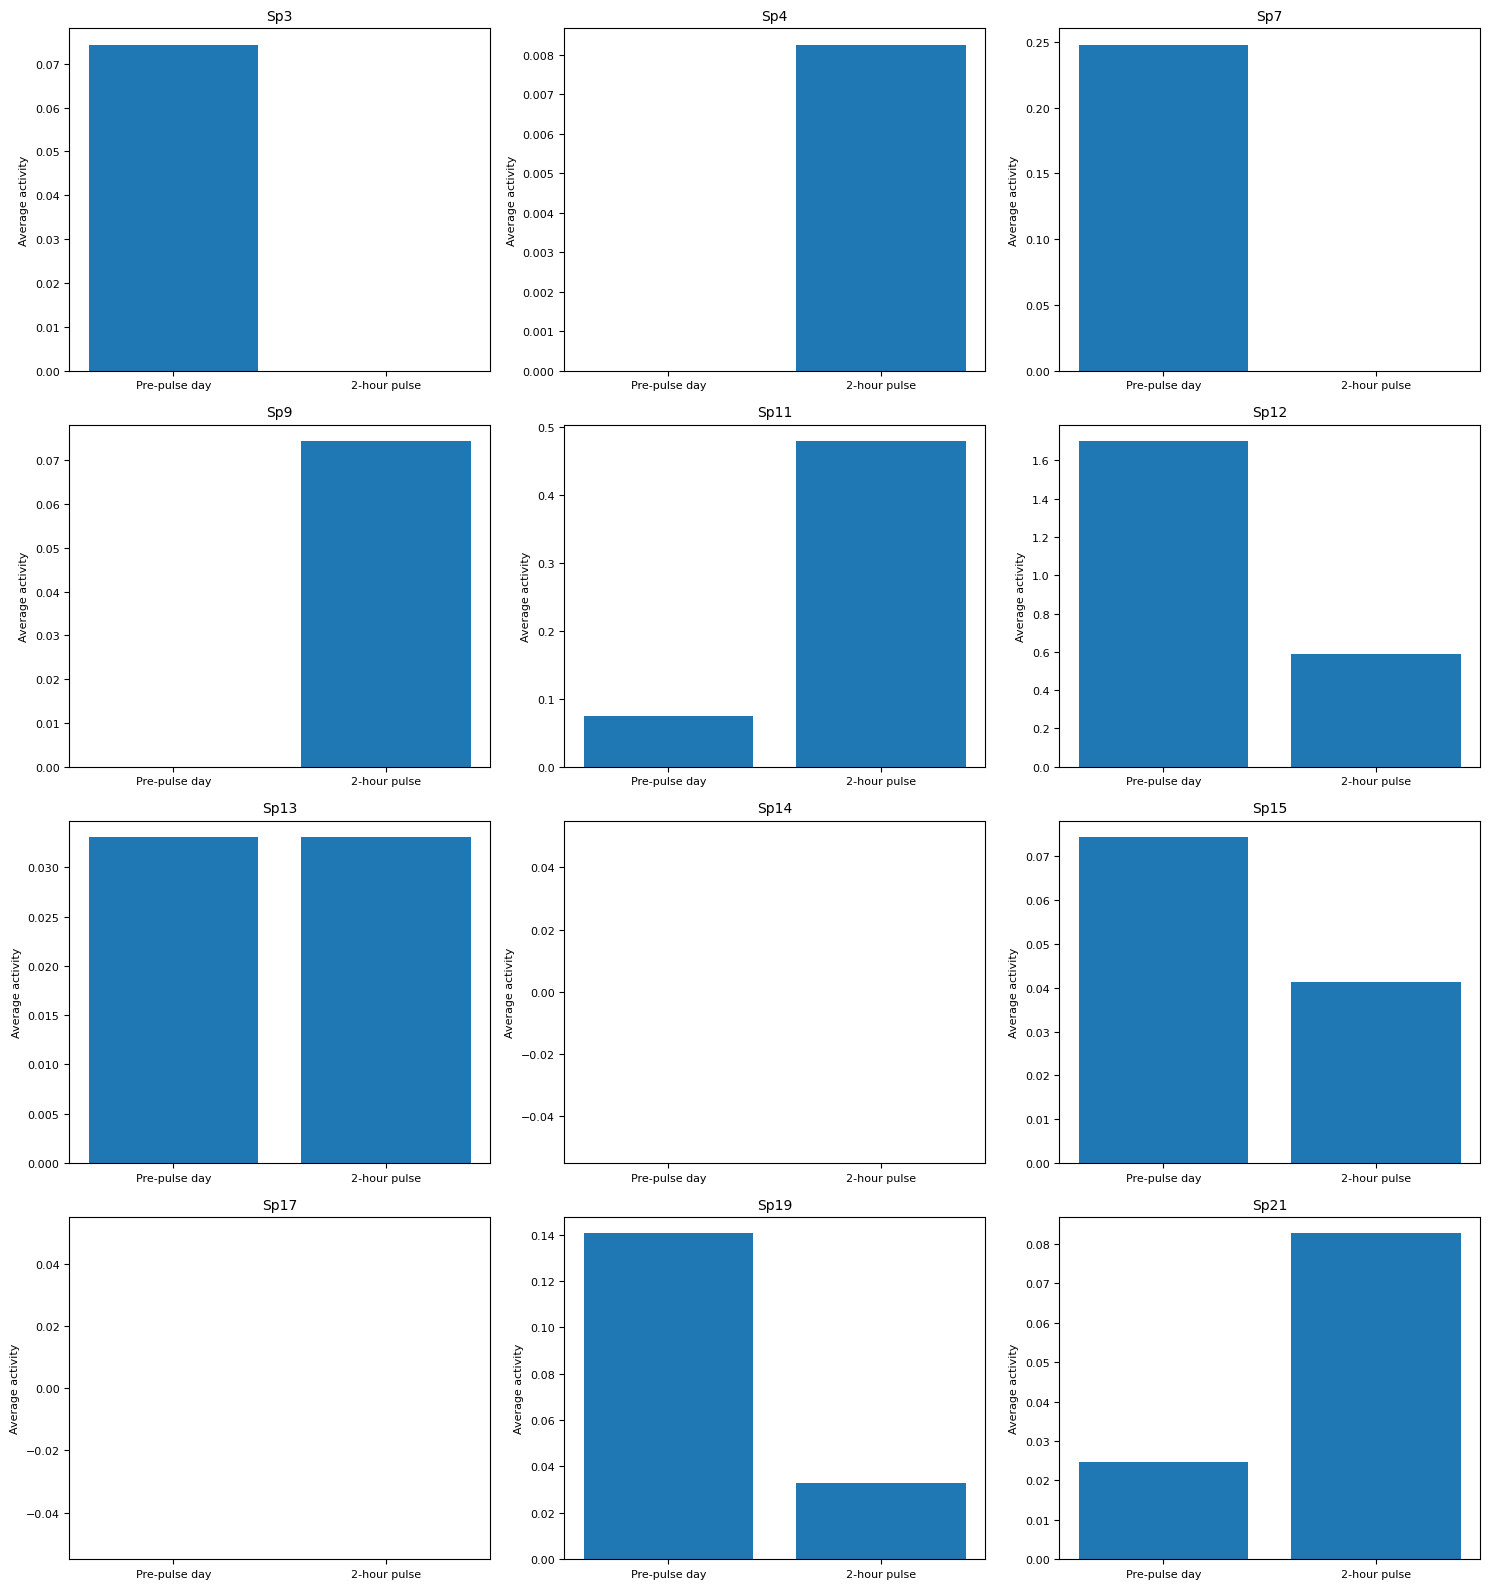

   Spider  Mean Pre-pulse Activity  Mean Pulse Activity
0     Sp3                 0.074380             0.000000
1     Sp4                 0.000000             0.008264
2     Sp7                 0.247934             0.000000
3     Sp9                 0.000000             0.074380
4    Sp11                 0.074380             0.479339
5    Sp12                 1.702479             0.586777
6    Sp13                 0.033058             0.033058
7    Sp14                 0.000000             0.000000
8    Sp15                 0.074380             0.041322
9    Sp17                 0.000000             0.000000
10   Sp19                 0.140496             0.033058
11   Sp21                 0.024793             0.082645


In [8]:
import pandas as pd
import matplotlib.pyplot as plt

def filter_and_compare_activity(df, day_pulse, day_pre_pulse, start_hour, end_hour):
    # Get the unique dates for the specified days
    pre_pulse_date = df.loc[df['Day'] == day_pre_pulse, 'Time'].dt.date.unique()[0]
    pulse_date = df.loc[df['Day'] == day_pulse, 'Time'].dt.date.unique()[0]
    
    # Construct start and end times with the correct dates
    start_time_pre_pulse = pd.to_datetime(f"{pre_pulse_date} {start_hour}")
    end_time_pre_pulse = pd.to_datetime(f"{pre_pulse_date} {end_hour}")
    start_time_pulse = pd.to_datetime(f"{pulse_date} {start_hour}")
    end_time_pulse = pd.to_datetime(f"{pulse_date} {end_hour}")
    
    # Filter the days
    day_pre = df.loc[df['Day'] == day_pre_pulse]
    day_pulse = df.loc[df['Day'] == day_pulse]
    
    # Filter the time range for the specified days
    day_pre_filtered = day_pre[(day_pre['Time'] >= start_time_pre_pulse) & (day_pre['Time'] <= end_time_pre_pulse)]
    day_pulse_filtered = day_pulse[(day_pulse['Time'] >= start_time_pulse) & (day_pulse['Time'] <= end_time_pulse)]
    
    # Initialize a list to store mean activity data for each spider
    spider_means = []
    
    # Loop through each spider column
    spider_columns = [col for col in df.columns if col.startswith('Sp')]
    
    # Calculate the number of rows and columns for the grid
    num_spiders = len(spider_columns)
    num_cols = 3  # You can adjust this value based on how many columns you want in the grid
    num_rows = (num_spiders + num_cols - 1) // num_cols  # Calculate the number of rows needed

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 4))
    axes = axes.flatten()  # Flatten the axes array to easily index it
    
    for idx, spider_col in enumerate(spider_columns):
        # Filter for the specific spider column
        spider_day_pre = day_pre_filtered[spider_col]
        spider_day_pulse = day_pulse_filtered[spider_col]
        
        # Calculate the mean activity
        mean_day_pre = spider_day_pre.mean()
        mean_day_pulse = spider_day_pulse.mean()
        
        # Append the results to the spider_means list
        spider_means.append((spider_col, mean_day_pre, mean_day_pulse))
        
        # Plot the results for each spider in the grid
        ax = axes[idx]
        days = ['Pre-pulse day', '2-hour pulse']
        means = [mean_day_pre, mean_day_pulse]
        
        ax.bar(days, means)
        ax.set_title(f'{spider_col}', fontsize=10)
        ax.set_ylabel('Average activity', fontsize=8)
        ax.set_xticks([0, 1])
        ax.set_xticklabels(days, fontsize=8)
        ax.tick_params(axis='y', labelsize=8)
    
    # Remove any empty subplots
    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()
    
    # Create a DataFrame to store the means for all spiders
    means_df = pd.DataFrame(spider_means, columns=['Spider', 'Mean Pre-pulse Activity', 'Mean Pulse Activity'])
    
    return means_df

# Example usage
# Define the parameters
day_pulse = 5  # The day when the pulse occurred
day_pre_pulse = 4  # The day before the pulse
start_hour = '14:00:00'  # Replace with the desired start hour
end_hour = '16:00:00'  # Replace with the desired end hour

# Ensure 'Time' is in datetime format
merged_dfx1['Time'] = pd.to_datetime(merged_dfx1['Time'])

# Call the function using the existing df
means_df = filter_and_compare_activity(merged_dfx1, day_pulse, day_pre_pulse, start_hour, end_hour)
print(means_df)


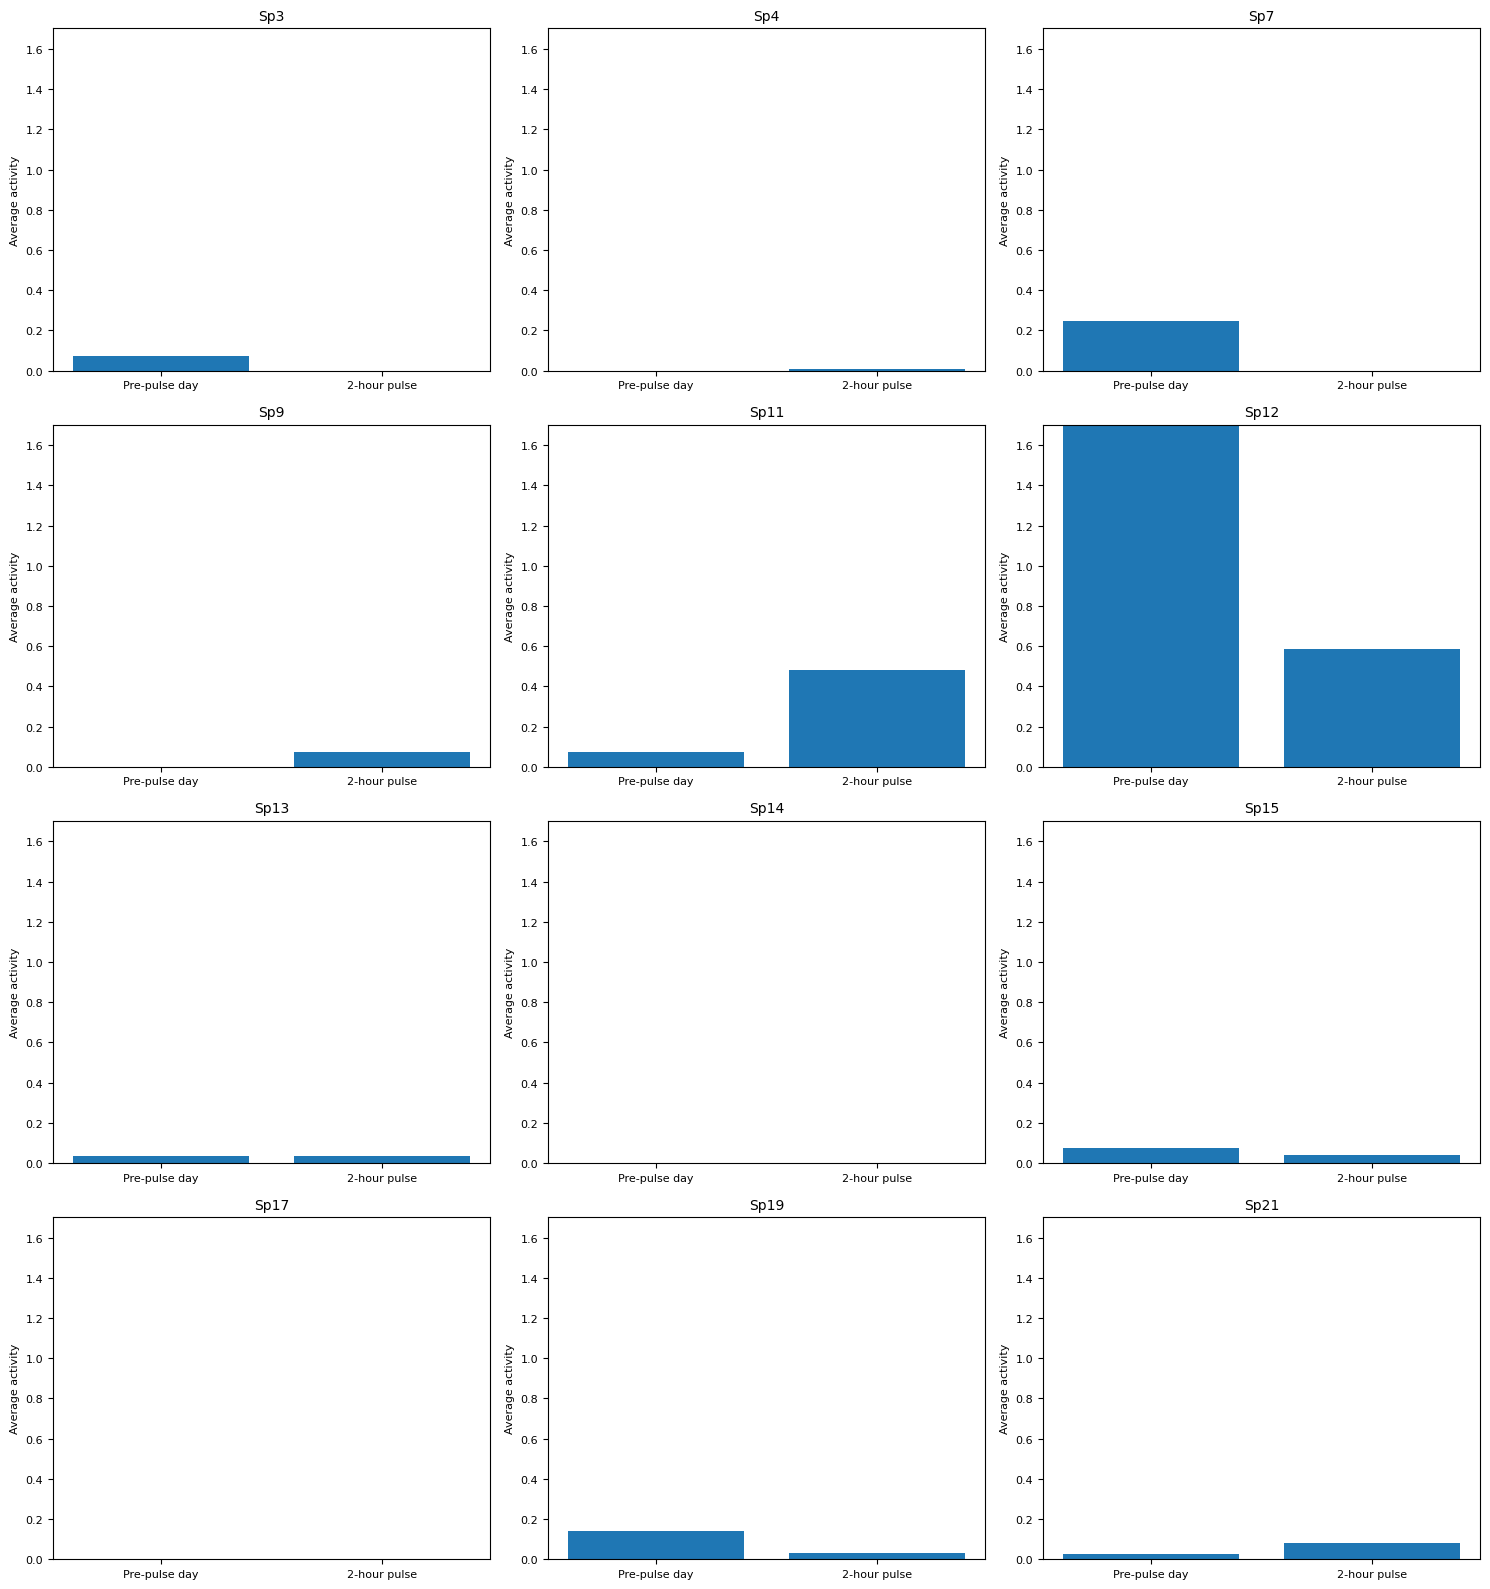

   Spider  Mean Pre-pulse Activity  Mean Pulse Activity
0     Sp3                 0.074380             0.000000
1     Sp4                 0.000000             0.008264
2     Sp7                 0.247934             0.000000
3     Sp9                 0.000000             0.074380
4    Sp11                 0.074380             0.479339
5    Sp12                 1.702479             0.586777
6    Sp13                 0.033058             0.033058
7    Sp14                 0.000000             0.000000
8    Sp15                 0.074380             0.041322
9    Sp17                 0.000000             0.000000
10   Sp19                 0.140496             0.033058
11   Sp21                 0.024793             0.082645


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def filter_and_compare_activity(df, day_pulse, day_pre_pulse, start_hour, end_hour):
    # Get the unique dates for the specified days
    pre_pulse_date = df.loc[df['Day'] == day_pre_pulse, 'Time'].dt.date.unique()[0]
    pulse_date = df.loc[df['Day'] == day_pulse, 'Time'].dt.date.unique()[0]
    
    # Construct start and end times with the correct dates
    start_time_pre_pulse = pd.to_datetime(f"{pre_pulse_date} {start_hour}")
    end_time_pre_pulse = pd.to_datetime(f"{pre_pulse_date} {end_hour}")
    start_time_pulse = pd.to_datetime(f"{pulse_date} {start_hour}")
    end_time_pulse = pd.to_datetime(f"{pulse_date} {end_hour}")
    
    # Filter the days
    day_pre = df.loc[df['Day'] == day_pre_pulse]
    day_pulse = df.loc[df['Day'] == day_pulse]
    
    # Filter the time range for the specified days
    day_pre_filtered = day_pre[(day_pre['Time'] >= start_time_pre_pulse) & (day_pre['Time'] <= end_time_pre_pulse)]
    day_pulse_filtered = day_pulse[(day_pulse['Time'] >= start_time_pulse) & (day_pulse['Time'] <= end_time_pulse)]
    
    # Initialize a list to store mean activity data for each spider
    spider_means = []
    
    # Loop through each spider column
    spider_columns = [col for col in df.columns if col.startswith('Sp')]
    
    # Calculate the number of rows and columns for the grid
    num_spiders = len(spider_columns)
    num_cols = 3  # You can adjust this value based on how many columns you want in the grid
    num_rows = (num_spiders + num_cols - 1) // num_cols  # Calculate the number of rows needed

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 4))
    axes = axes.flatten()  # Flatten the axes array to easily index it
    
    for idx, spider_col in enumerate(spider_columns):
        # Filter for the specific spider column
        spider_day_pre = day_pre_filtered[spider_col]
        spider_day_pulse = day_pulse_filtered[spider_col]
        
        # Calculate the mean activity
        mean_day_pre = spider_day_pre.mean()
        mean_day_pulse = spider_day_pulse.mean()
        
        # Append the results to the spider_means list
        spider_means.append((spider_col, mean_day_pre, mean_day_pulse))
        
        # Plot the results for each spider in the grid
        ax = axes[idx]
        days = ['Pre-pulse day', '2-hour pulse']
        means = [mean_day_pre, mean_day_pulse]
        
        ax.bar(days, means)
        ax.set_title(f'{spider_col}', fontsize=10)
        ax.set_ylabel('Average activity', fontsize=8)
        ax.set_xticks([0, 1])
        ax.set_xticklabels(days, fontsize=8)
        ax.tick_params(axis='y', labelsize=8)
    
    # Remove any empty subplots
    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])
    
    # Find the maximum mean activity across all spiders
    max_mean_activity = max([mean for _, mean_pre, mean_pulse in spider_means for mean in (mean_pre, mean_pulse)])
    
    # Set the same y-axis range for all subplots
    for ax in axes:
        ax.set_ylim(0, max_mean_activity)
    
    plt.tight_layout()
    plt.show()
    
    # Create a DataFrame to store the means for all spiders
    means_df = pd.DataFrame(spider_means, columns=['Spider', 'Mean Pre-pulse Activity', 'Mean Pulse Activity'])
    
    return means_df

# Example usage
# Define the parameters
day_pulse = 5  # The day when the pulse occurred
day_pre_pulse = 4  # The day before the pulse
start_hour = '14:00:00'  # Replace with the desired start hour
end_hour = '16:00:00'  # Replace with the desired end hour

# Ensure 'Time' is in datetime format
merged_dfx1['Time'] = pd.to_datetime(merged_dfx1['Time'])

# Call the function using the existing df
means_df = filter_and_compare_activity(merged_dfx1, day_pulse, day_pre_pulse, start_hour, end_hour)
print(means_df)


In [10]:
# filtering for a single day 
day1 = df[df['Day'] == 1]
count_mov = day1.filter(like="Sp")  
sum_count = count_mov.sum(axis=0) 
threshold = 0
filter_sum = sum_count > threshold 
columns_to_keep = filter_sum[filter_sum].index  
additional_columns = df.columns[:3]
all_columns_to_keep = list(additional_columns) + list(columns_to_keep)
filtered_df = day1[all_columns_to_keep]
display(filtered_df)

,Day,Time,Light,Sp3,Sp4,Sp5,Sp7,Sp9,Sp10,Sp11,...,Sp14,Sp15,Sp16,Sp17,Sp18,Sp19,Sp21,Sp22,Sp23,Sp25
Index,,,,,,,,,,,,,,,,,,,,,
14,1,2024-04-17 15:56:00,1,0,16,0,2,0,0,0,...,0,0,0,0,0,2,0,0,0,0
15,1,2024-04-17 15:57:00,1,0,8,0,3,0,0,0,...,0,0,0,0,0,1,0,0,0,0
16,1,2024-04-17 15:58:00,1,0,8,0,4,0,1,0,...,0,0,0,0,0,6,0,0,0,0
17,1,2024-04-17 15:59:00,1,0,15,0,2,0,3,0,...,0,0,0,0,0,1,0,0,0,0
18,1,2024-04-17 16:00:00,1,0,9,0,2,0,0,0,...,0,0,0,0,0,4,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,1,2024-04-17 23:55:00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
494,1,2024-04-17 23:56:00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
495,1,2024-04-17 23:57:00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
#filtering for all days 
import pandas as pd

threshold = 0
additional_columns = df.columns[:3]
filtered_dfs = []

for day in range(1, 9):  
    day_df = df[df['Day'] == day] 
    count_mov = day_df.filter(like="Sp")  
    x = count_mov.sum(axis=0)  
    z = x > threshold  
    columns_to_keep = z[z].index 
    
    all_columns_to_keep = list(additional_columns) + list(columns_to_keep)
    filtered_df = day_df[all_columns_to_keep]
    filtered_dfs.append(filtered_df)

merged_df = pd.concat(filtered_dfs)
merged_df1 = merged_df.dropna(axis=1)
display(merged_df1)

,Day,Time,Light,Sp3,Sp4,Sp7,Sp9,Sp10,Sp11,Sp12,Sp13,Sp14,Sp15,Sp17,Sp19,Sp21,Sp25
Index,,,,,,,,,,,,,,,,,
14,1,2024-04-17 15:56:00,1,0,16,2,0,0,0,26,0,0,0,0,2,0,0
15,1,2024-04-17 15:57:00,1,0,8,3,0,0,0,17,0,0,0,0,1,0,0
16,1,2024-04-17 15:58:00,1,0,8,4,0,1,0,19,0,0,0,0,6,0,0
17,1,2024-04-17 15:59:00,1,0,15,2,0,3,0,11,0,0,0,0,1,0,0
18,1,2024-04-17 16:00:00,1,0,9,2,0,0,0,14,6,0,0,0,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10036,8,2024-04-24 14:58:00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10037,8,2024-04-24 14:59:00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10038,8,2024-04-24 15:00:00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
#function to filter 
import pandas as pd

def filter_and_merge(df, threshold=0):
    additional_columns = df.columns[:3]
    filtered_dfs = []

    for day in range(1, 9):  
        day_df = df[df['Day'] == day] 
        count_mov = day_df.filter(like="Sp")  
        x = count_mov.sum(axis=0)  
        z = x > threshold  
        columns_to_keep = z[z].index 
        
        all_columns_to_keep = list(additional_columns) + list(columns_to_keep)
        filtered_df = day_df[all_columns_to_keep]
        filtered_dfs.append(filtered_df)

    merged_df = pd.concat(filtered_dfs)
    merged_df1 = merged_df.dropna(axis=1)
    
    return merged_df1
    
merged_df = filter_and_merge(df)
display(merged_df)

,Day,Time,Light,Sp3,Sp4,Sp7,Sp9,Sp10,Sp11,Sp12,Sp13,Sp14,Sp15,Sp17,Sp19,Sp21,Sp25
Index,,,,,,,,,,,,,,,,,
14,1,2024-04-17 15:56:00,1,0,16,2,0,0,0,26,0,0,0,0,2,0,0
15,1,2024-04-17 15:57:00,1,0,8,3,0,0,0,17,0,0,0,0,1,0,0
16,1,2024-04-17 15:58:00,1,0,8,4,0,1,0,19,0,0,0,0,6,0,0
17,1,2024-04-17 15:59:00,1,0,15,2,0,3,0,11,0,0,0,0,1,0,0
18,1,2024-04-17 16:00:00,1,0,9,2,0,0,0,14,6,0,0,0,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10036,8,2024-04-24 14:58:00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10037,8,2024-04-24 14:59:00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10038,8,2024-04-24 15:00:00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
#have the dataframes all at once 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os

def process_file(file):
    col_names = ["Index", "DateD", "DateM", "DateY", "Time", "MonStatus", "Extras", "MonN", "TubeN", "DataType", "Unused", "Light"]
    
    for i in range(1, 33):
        col_names.append(f"Sp{i}")
    
    df = pd.read_csv(file, names=col_names, sep='\s+', header=None)
    df = df.set_index('Index')
    df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S', errors='coerce')
    df = df[df["MonStatus"] == 1]

    month_map = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6}
    df['DateM'] = df['DateM'].str[:3].map(month_map)
    df['DateY'] = df['DateY'].apply(lambda x: int(str(20) + str(x)))
    df['Date'] = pd.to_datetime(dict(year=df['DateY'], month=df['DateM'], day=df['DateD']), errors='coerce')

    df['Time'] = pd.to_datetime(dict(year=df['Date'].dt.year,
                                     month=df['Date'].dt.month,
                                     day=df['Date'].dt.day,
                                     hour=df['Time'].dt.hour,
                                     minute=df['Time'].dt.minute,
                                     second=df['Time'].dt.second))

    df = df.drop(["DateD", "DateM", "DateY", "Date", "MonStatus", "Extras", "MonN", "TubeN", "DataType", "Unused"], axis=1)

    day_map = {day: idx+1 for idx, day in enumerate(df['Time'].dt.day.unique())}

    df.insert(0, 'Day', df['Time'].dt.day.map(day_map))
    
    return df

def process_files(files):
    dataframes = {}
    for idx, file in enumerate(files, start=1):
        df = process_file(file)
        dataframes[f'df{idx}'] = df
    return dataframes

files = ['Steatoda A masking 02 pm.txt', 'Steatoda A masking 10 am.txt', 'Steatoda A masking 4 am.txt', 'Steatoda A masking midnight.txt', 'Steatoda B masking 04 pm.txt', 'Steatoda B masking 10 pm.txt', 'Steatoda B masking 12 pm.txt', 'Steatoda B maskng 2am.txt']

dataframes = process_files(files)
for name, df in dataframes.items():
    print(f"{name}:")
    display(df)


FileNotFoundError: [Errno 2] No such file or directory: 'Steatoda A masking 02 pm.txt'

In [ ]:
filter_and_merge(df, threshold=0)

In [ ]:
#have the dataframes all at once 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os

def process_file(file):
    col_names = ["Index", "DateD", "DateM", "DateY", "Time", "MonStatus", "Extras", "MonN", "TubeN", "DataType", "Unused", "Light"]
    
    for i in range(1, 33):
        col_names.append(f"Sp{i}")
    
    df = pd.read_csv(file, names=col_names, sep='\s+', header=None)
    df = df.set_index('Index')
    df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S', errors='coerce')
    df = df[df["MonStatus"] == 1]

    month_map = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6}
    df['DateM'] = df['DateM'].str[:3].map(month_map)
    df['DateY'] = df['DateY'].apply(lambda x: int(str(20) + str(x)))
    df['Date'] = pd.to_datetime(dict(year=df['DateY'], month=df['DateM'], day=df['DateD']), errors='coerce')

    df['Time'] = pd.to_datetime(dict(year=df['Date'].dt.year,
                                     month=df['Date'].dt.month,
                                     day=df['Date'].dt.day,
                                     hour=df['Time'].dt.hour,
                                     minute=df['Time'].dt.minute,
                                     second=df['Time'].dt.second))

    df = df.drop(["DateD", "DateM", "DateY", "Date", "MonStatus", "Extras", "MonN", "TubeN", "DataType", "Unused"], axis=1)

    day_map = {day: idx+1 for idx, day in enumerate(df['Time'].dt.day.unique())}

    df.insert(0, 'Day', df['Time'].dt.day.map(day_map))
    
    return df

def process_files(files):
    dataframes = {}
    for idx, file in enumerate(files, start=1):
        df = process_file(file)
        dataframes[f'df{idx}'] = df
    return dataframes

files = ['Steatoda A masking 02 pm.txt', 'Steatoda A masking 10 am.txt', 'Steatoda A masking 4 am.txt', 'Steatoda A masking midnight.txt', 'Steatoda B masking 04 pm.txt', 'Steatoda B masking 10 pm.txt', 'Steatoda B masking 12 pm.txt', 'Steatoda B maskng 2am.txt']

dataframes = process_files(files)
for name, df in dataframes.items():
    print(f"{name}:")
    display(df)


In [ ]:
#have the dataframes all at once 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os

def process_file(file):
    col_names = ["Index", "DateD", "DateM", "DateY", "Time", "MonStatus", "Extras", "MonN", "TubeN", "DataType", "Unused", "Light"]
    
    for i in range(1, 33):
        col_names.append(f"Sp{i}")
    
    df = pd.read_csv(file, names=col_names, sep='\s+', header=None)
    df = df.set_index('Index')
    df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S', errors='coerce')
    df = df[df["MonStatus"] == 1]

    month_map = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6}
    df['DateM'] = df['DateM'].str[:3].map(month_map)
    df['DateY'] = df['DateY'].apply(lambda x: int(str(20) + str(x)))
    df['Date'] = pd.to_datetime(dict(year=df['DateY'], month=df['DateM'], day=df['DateD']), errors='coerce')

    df['Time'] = pd.to_datetime(dict(year=df['Date'].dt.year,
                                     month=df['Date'].dt.month,
                                     day=df['Date'].dt.day,
                                     hour=df['Time'].dt.hour,
                                     minute=df['Time'].dt.minute,
                                     second=df['Time'].dt.second))

    df = df.drop(["DateD", "DateM", "DateY", "Date", "MonStatus", "Extras", "MonN", "TubeN", "DataType", "Unused"], axis=1)

    day_map = {day: idx+1 for idx, day in enumerate(df['Time'].dt.day.unique())}

    df.insert(0, 'Day', df['Time'].dt.day.map(day_map))
    
    return df

def process_files(files):
    dataframes = {}
    for idx, file in enumerate(files, start=1):
        df = process_file(file)
        dataframes[f'df{idx}'] = df
    return dataframes

files = ['Steatoda A masking 02 pm.txt', 'Steatoda A masking 10 am.txt', 'Steatoda A masking 4 am.txt', 'Steatoda A masking midnight.txt', 'Steatoda B masking 04 pm.txt', 'Steatoda B masking 10 pm.txt', 'Steatoda B masking 12 pm.txt', 'Steatoda B maskng 2am.txt']

dataframes = process_files(files)
for name, df in dataframes.items():
    print(f"{name}:")
    display(df)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os

def process_file(file):
    col_names = ["Index", "DateD", "DateM", "DateY", "Time", "MonStatus", "Extras", "MonN", "TubeN", "DataType", "Unused", "Light"]
    
    for i in range(1, 33):
        col_names.append(f"Sp{i}")
    
    df = pd.read_csv(file, names=col_names, sep='\s+', header=None)
    df = df.set_index('Index')
    df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S', errors='coerce')
    df = df[df["MonStatus"] == 1]

    month_map = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6}
    df['DateM'] = df['DateM'].str[:3].map(month_map)
    df['DateY'] = df['DateY'].apply(lambda x: int(str(20) + str(x)))
    df['Date'] = pd.to_datetime(dict(year=df['DateY'], month=df['DateM'], day=df['DateD']), errors='coerce')

    df['Time'] = pd.to_datetime(dict(year=df['Date'].dt.year,
                                     month=df['Date'].dt.month,
                                     day=df['Date'].dt.day,
                                     hour=df['Time'].dt.hour,
                                     minute=df['Time'].dt.minute,
                                     second=df['Time'].dt.second))

    df = df.drop(["DateD", "DateM", "DateY", "Date", "MonStatus", "Extras", "MonN", "TubeN", "DataType", "Unused"], axis=1)

    day_map = {day: idx+1 for idx, day in enumerate(df['Time'].dt.day.unique())}

    df.insert(0, 'Day', df['Time'].dt.day.map(day_map))
    
    return df

def process_files(files):
    dataframes = {}
    for idx, file in enumerate(files, start=1):
        df = process_file(file)
        dataframes[f'df{idx}'] = df
    return dataframes

def filter_and_merge(dataframes, threshold=0):
    merged_filtered_dfs = []
    for name, df in dataframes.items():
        additional_columns = df.columns[:3]
        filtered_dfs = []

        for day in range(1, 9):  
            day_df = df[df['Day'] == day] 
            count_mov = day_df.filter(like="Sp")  
            x = count_mov.sum(axis=0)  
            z = x > threshold  
            columns_to_keep = z[z].index 

            all_columns_to_keep = list(additional_columns) + list(columns_to_keep)
            filtered_df = day_df[all_columns_to_keep]
            filtered_dfs.append(filtered_df)

        merged_df = pd.concat(filtered_dfs)
        merged_df1 = merged_df.dropna(axis=1)
        merged_filtered_dfs.append(merged_df1)
    
    final_merged_df = pd.concat(merged_filtered_dfs)
    return final_merged_df

files = [
    'Steatoda A masking 02 pm.txt', 'Steatoda A masking 10 am.txt',
    'Steatoda A masking 4 am.txt', 'Steatoda A masking midnight.txt',
    'Steatoda B masking 04 pm.txt', 'Steatoda B masking 10 pm.txt',
    'Steatoda B masking 12 pm.txt', 'Steatoda B maskng 2am.txt'
]

dataframes = process_files(files)

final_merged_df = filter_and_merge(dataframes, threshold=0)

display(final_merged_df)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os

def process_file(file):
    col_names = ["Index", "DateD", "DateM", "DateY", "Time", "MonStatus", "Extras", "MonN", "TubeN", "DataType", "Unused", "Light"]
    
    for i in range(1, 33):
        col_names.append(f"Sp{i}")
    
    df = pd.read_csv(file, names=col_names, sep='\s+', header=None)
    df = df.set_index('Index')
    df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S', errors='coerce')
    df = df[df["MonStatus"] == 1]

    month_map = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6}
    df['DateM'] = df['DateM'].str[:3].map(month_map)
    df['DateY'] = df['DateY'].apply(lambda x: int(str(20) + str(x)))
    df['Date'] = pd.to_datetime(dict(year=df['DateY'], month=df['DateM'], day=df['DateD']), errors='coerce')

    df['Time'] = pd.to_datetime(dict(year=df['Date'].dt.year,
                                     month=df['Date'].dt.month,
                                     day=df['Date'].dt.day,
                                     hour=df['Time'].dt.hour,
                                     minute=df['Time'].dt.minute,
                                     second=df['Time'].dt.second))

    df = df.drop(["DateD", "DateM", "DateY", "Date", "MonStatus", "Extras", "MonN", "TubeN", "DataType", "Unused"], axis=1)

    day_map = {day: idx+1 for idx, day in enumerate(df['Time'].dt.day.unique())}

    df.insert(0, 'Day', df['Time'].dt.day.map(day_map))
    
    return df

def process_files(files):
    dataframes = {}
    for idx, file in enumerate(files, start=1):
        df = process_file(file)
        dataframes[f'df{idx}'] = df
    return dataframes

def filter_and_merge(dataframes, threshold=0):
    filtered_dataframes = {}
    for name, df in dataframes.items():
        additional_columns = df.columns[:3]
        filtered_dfs = []

        for day in range(1, 9):  
            day_df = df[df['Day'] == day] 
            count_mov = day_df.filter(like="Sp")  
            x = count_mov.sum(axis=0)  
            z = x > threshold  
            columns_to_keep = z[z].index 

            all_columns_to_keep = list(additional_columns) + list(columns_to_keep)
            filtered_df = day_df[all_columns_to_keep]
            filtered_dfs.append(filtered_df)

        merged_df = pd.concat(filtered_dfs)
        merged_df1 = merged_df.dropna(axis=1)
        filtered_dataframes[name] = merged_df1
    
    return filtered_dataframes

# List of files to process
files = [
    'Steatoda A masking 02 pm.txt', 'Steatoda A masking 10 am.txt',
    'Steatoda A masking 4 am.txt', 'Steatoda A masking midnight.txt',
    'Steatoda B masking 04 pm.txt', 'Steatoda B masking 10 pm.txt',
    'Steatoda B masking 12 pm.txt', 'Steatoda B maskng 2am.txt'
]

dataframes = process_files(files)

filtered_dataframes = filter_and_merge(dataframes, threshold=0)

for name, df in filtered_dataframes.items():
    print(f"{name}:")
    display(df)


In [ ]:
#FINDING THE SPIDERS IN GROUP A AND B THAT HAVE DATA ACROSS ALL GROUPS
#have the dataframes all at once 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os

def process_file(file):
    col_names = ["Index", "DateD", "DateM", "DateY", "Time", "MonStatus", "Extras", "MonN", "TubeN", "DataType", "Unused", "Light"]
    
    for i in range(1, 33):
        col_names.append(f"Sp{i}")
    
    df = pd.read_csv(file, names=col_names, sep='\s+', header=None)
    df = df.set_index('Index')
    df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S', errors='coerce')
    df = df[df["MonStatus"] == 1]

    month_map = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6}
    df['DateM'] = df['DateM'].str[:3].map(month_map)
    df['DateY'] = df['DateY'].apply(lambda x: int(str(20) + str(x)))
    df['Date'] = pd.to_datetime(dict(year=df['DateY'], month=df['DateM'], day=df['DateD']), errors='coerce')

    df['Time'] = pd.to_datetime(dict(year=df['Date'].dt.year,
                                     month=df['Date'].dt.month,
                                     day=df['Date'].dt.day,
                                     hour=df['Time'].dt.hour,
                                     minute=df['Time'].dt.minute,
                                     second=df['Time'].dt.second))

    df = df.drop(["DateD", "DateM", "DateY", "Date", "MonStatus", "Extras", "MonN", "TubeN", "DataType", "Unused"], axis=1)

    day_map = {day: idx+1 for idx, day in enumerate(df['Time'].dt.day.unique())}

    df.insert(0, 'Day', df['Time'].dt.day.map(day_map))
    
    return df

def process_files(files):
    dataframes = {}
    for idx, file in enumerate(files, start=1):
        df = process_file(file)
        dataframes[f'df{idx}'] = df
    return dataframes

files = ['Steatoda A masking 02 pm.txt', 'Steatoda A masking 10 am.txt', 'Steatoda A masking 4 am.txt', 'Steatoda A masking midnight.txt', 'Steatoda B masking 04 pm.txt', 'Steatoda B masking 10 pm.txt', 'Steatoda B masking 12 pm.txt', 'Steatoda B maskng 2am.txt']

dataframes = process_files(files)
for name, df in dataframes.items():
    print(f"{name}:")
    display(df)
    
#FILTER THRESHOLD

#FILTER ENTRAINMENT AND OUTPUT THE ONES THAT ARE ENTRAINED 

#CROSS SETS 





In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os

def process_file(file):
    col_names = ["Index", "DateD", "DateM", "DateY", "Time", "MonStatus", "Extras", "MonN", "TubeN", "DataType", "Unused", "Light"]
    
    for i in range(1, 33):
        col_names.append(f"Sp{i}")
    
    df = pd.read_csv(file, names=col_names, sep='\s+', header=None)
    df = df.set_index('Index')
    df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S', errors='coerce')
    df = df[df["MonStatus"] == 1]

    month_map = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6}
    df['DateM'] = df['DateM'].str[:3].map(month_map)
    df['DateY'] = df['DateY'].apply(lambda x: int(str(20) + str(x)))
    df['Date'] = pd.to_datetime(dict(year=df['DateY'], month=df['DateM'], day=df['DateD']), errors='coerce')

    df['Time'] = pd.to_datetime(dict(year=df['Date'].dt.year,
                                     month=df['Date'].dt.month,
                                     day=df['Date'].dt.day,
                                     hour=df['Time'].dt.hour,
                                     minute=df['Time'].dt.minute,
                                     second=df['Time'].dt.second))

    df = df.drop(["DateD", "DateM", "DateY", "Date", "MonStatus", "Extras", "MonN", "TubeN", "DataType", "Unused"], axis=1)

    day_map = {day: idx+1 for idx, day in enumerate(df['Time'].dt.day.unique())}

    df.insert(0, 'Day', df['Time'].dt.day.map(day_map))
    
    return df

def process_files(files):
    dataframes = {}
    for idx, file in enumerate(files, start=1):
        df = process_file(file)
        dataframes[f'df{idx}'] = df
    return dataframes

def filter_and_merge(dataframes, threshold=0):
    merged_filtered_dfs = []
    for name, df in dataframes.items():
        additional_columns = df.columns[:3]
        filtered_dfs = []

        for day in range(1, 9):  
            day_df = df[df['Day'] == day] 
            count_mov = day_df.filter(like="Sp")  
            x = count_mov.sum(axis=0)  
            z = x > threshold  
            columns_to_keep = z[z].index 

            all_columns_to_keep = list(additional_columns) + list(columns_to_keep)
            filtered_df = day_df[all_columns_to_keep]
            filtered_dfs.append(filtered_df)

        merged_df = pd.concat(filtered_dfs)
        merged_df1 = merged_df.dropna(axis=1)
        merged_filtered_dfs.append(merged_df1)
    
    final_merged_df = pd.concat(merged_filtered_dfs)
    return final_merged_df

files = [
    'Steatoda A masking 02 pm.txt', 'Steatoda A masking 10 am.txt',
    'Steatoda A masking 4 am.txt', 'Steatoda A masking midnight.txt',
    'Steatoda B masking 04 pm.txt', 'Steatoda B masking 10 pm.txt',
    'Steatoda B masking 12 pm.txt', 'Steatoda B maskng 2am.txt'
]

dataframes = process_files(files)

final_merged_df = filter_and_merge(dataframes, threshold=0)

final_merged_df = student_df.dropna(axis='columns')

display(final_merged_df)

